<a href="https://colab.research.google.com/github/Saoudyahya/mechanistic-interpretability/blob/main/mechanistic_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.57MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.82MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 11.9MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training completed.


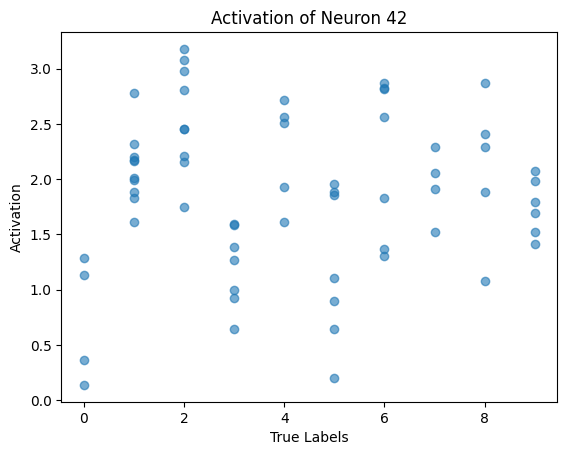

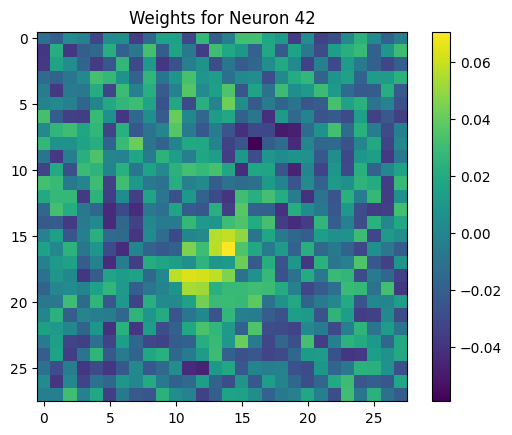

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step 1: Define the Model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 10)      # Output layer

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        self.activations = x.detach()  # Store activations for interpretability
        x = self.fc2(x)
        return x

# Step 2: Prepare the Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

# Step 3: Train the Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Training completed.")

# Step 4: Interpret the Activations
# Fetch activations for a sample
sample_images, sample_labels = next(iter(train_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
model(sample_images)  # Forward pass
activations = model.activations  # Extract stored activations

# Step 5: Analyze a Specific Neuron
# Choose a neuron and visualize its response
neuron_idx = 42  # Example: 42nd neuron
responses = activations[:, neuron_idx].cpu().numpy()

# Plot activations against the labels
plt.scatter(sample_labels.cpu().numpy(), responses, alpha=0.6)
plt.title(f"Activation of Neuron {neuron_idx}")
plt.xlabel("True Labels")
plt.ylabel("Activation")
plt.show()

# Step 6: Investigate Input Features
# Visualize the weights of the selected neuron
weights = model.fc1.weight[neuron_idx].view(28, 28).cpu().detach().numpy()
plt.imshow(weights, cmap='viridis')
plt.title(f"Weights for Neuron {neuron_idx}")
plt.colorbar()
plt.show()


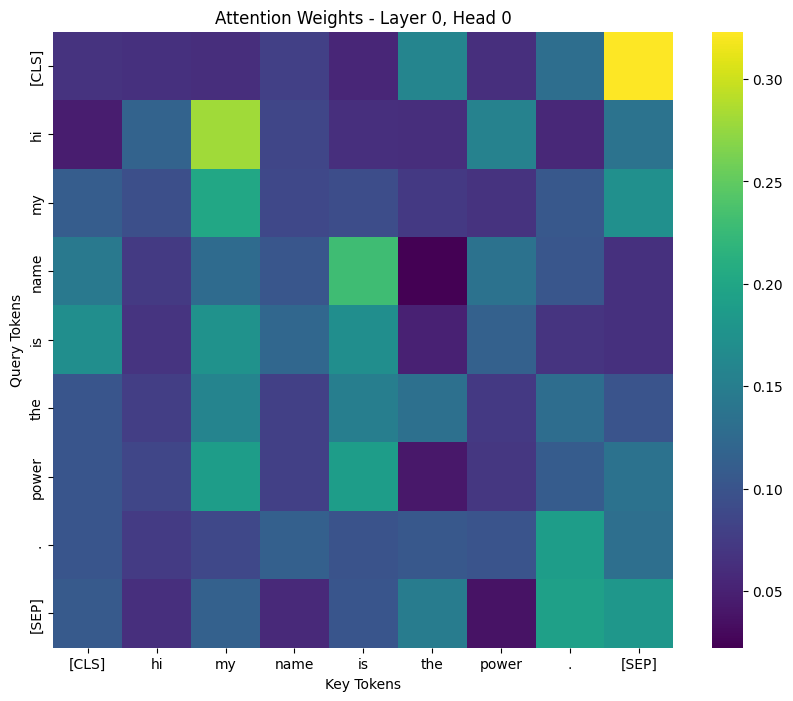

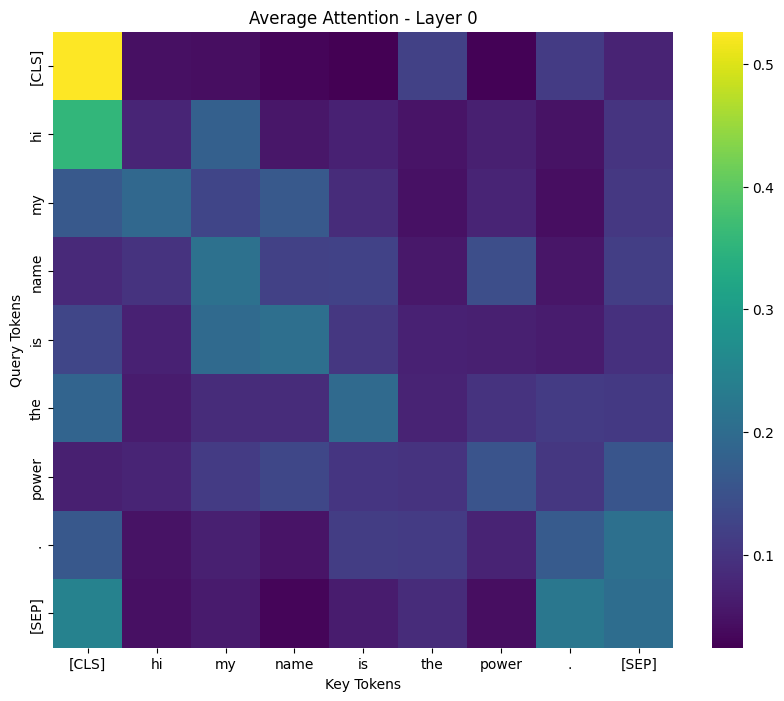

In [4]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Pre-Trained Transformer Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Step 2: Input Text for Analysis
text = "hi my name is the power ."
inputs = tokenizer(text, return_tensors="pt")

# Step 3: Forward Pass to Get Attention Weights
outputs = model(**inputs)
attentions = outputs.attentions  # Tuple of attention weights for all layers

# Step 4: Choose a Specific Layer and Head
layer = 0  # First layer
head = 0   # First attention head

attention_weights = attentions[layer][0, head].detach().numpy()  # Shape: (seq_len, seq_len)

# Step 5: Visualize Attention for a Token
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
seq_len = len(tokens)

plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Attention Weights - Layer {layer}, Head {head}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Step 6: Investigate Attention Across Layers
# Summing attention weights across all heads for layer 0
average_attention = attentions[layer][0].mean(dim=0).detach().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(average_attention[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Average Attention - Layer {layer}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


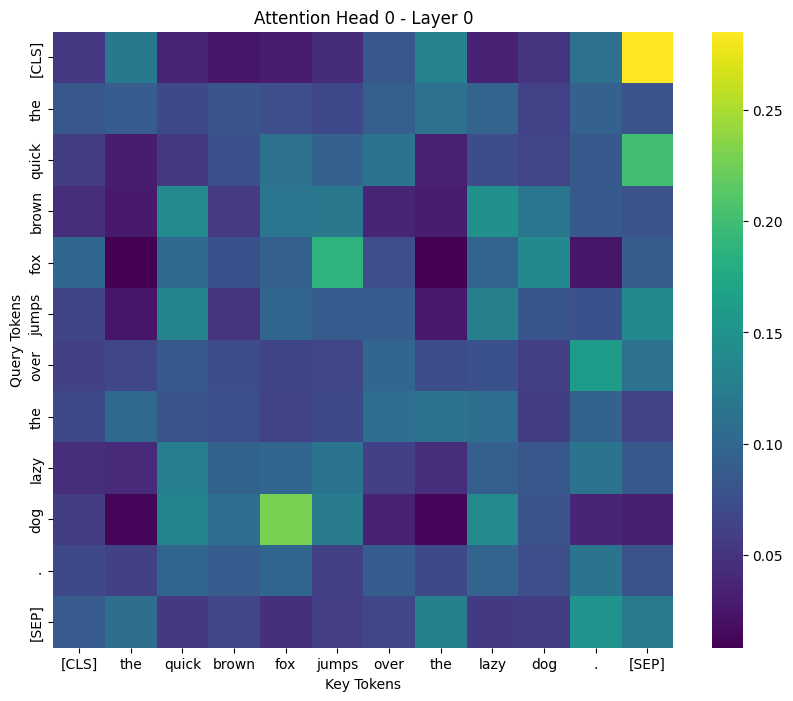

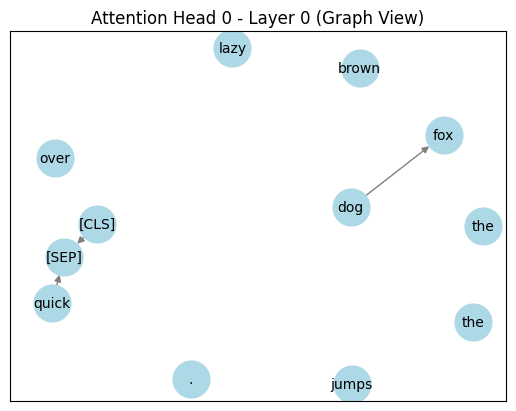

In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load Pre-Trained Transformer Model
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_attentions=True)

# Step 2: Input Text for Analysis
text = "The quick brown fox jumps over the lazy dog."
inputs = tokenizer(text, return_tensors="pt")

# Step 3: Forward Pass to Get Attention Weights
outputs = model(**inputs)
attentions = outputs.attentions  # Tuple of attention weights (num_layers, batch_size, num_heads, seq_len, seq_len)

# Step 4: Choose a Specific Layer and Head for Analysis
layer = 0  # First layer
head = 0   # First attention head

# Extract attention weights for the selected layer and head
attention_weights = attentions[layer][0, head].detach().numpy()  # Shape: (seq_len, seq_len)

# Get tokenized words
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
seq_len = len(tokens)

# Step 5: Visualize Attention for the Specific Head
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Attention Head {head} - Layer {layer}")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()

# Step 6: Visualize Attention Weights as a Graph (Optional)
import networkx as nx

# Create a directed graph to show token relationships
graph = nx.DiGraph()
for i, token in enumerate(tokens):
    graph.add_node(i, label=token)

# Add edges based on attention weights (only the strongest connections)
for i in range(seq_len):
    for j in range(seq_len):
        if attention_weights[i, j] > 0.2:  # Threshold for clarity
            graph.add_edge(i, j, weight=attention_weights[i, j])

# Plot the graph
pos = nx.spring_layout(graph)
labels = nx.get_node_attributes(graph, 'label')
nx.draw_networkx(graph, pos, labels=labels, node_color='lightblue', edge_color='gray', font_size=10, node_size=700)
plt.title(f"Attention Head {head} - Layer {layer} (Graph View)")
plt.show()


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


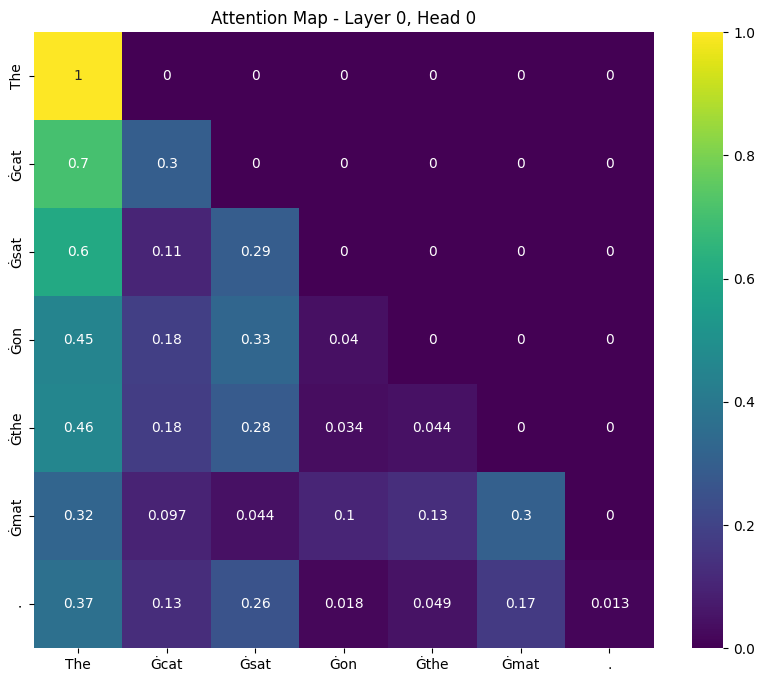

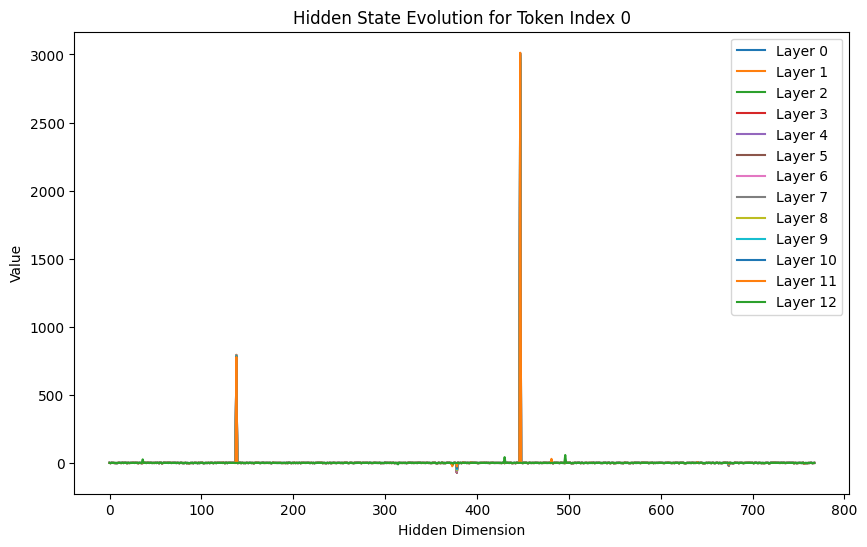

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load a pre-trained LLM
model_name = "gpt2"  # You can replace this with other models like "bert-base-uncased"
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example input
text = "The cat sat on the mat."
inputs = tokenizer(text, return_tensors="pt")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Extract attention weights and hidden states
attentions = outputs.attentions  # A tuple of (num_layers, batch_size, num_heads, seq_len, seq_len)
hidden_states = outputs.hidden_states  # A tuple of (num_layers + 1, batch_size, seq_len, hidden_size)

# Analyze attention weights
def visualize_attention(attentions, layer_idx, head_idx):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Choose a specific layer and head
    attention_matrix = attentions[layer_idx][0, head_idx].cpu().numpy()

    # Plot attention as a heatmap
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap="viridis", annot=True)
    plt.title(f"Attention Map - Layer {layer_idx}, Head {head_idx}")
    plt.show()

visualize_attention(attentions, layer_idx=0, head_idx=0)

# Analyze hidden states
def analyze_hidden_states(hidden_states, token_idx):
    token_hidden_states = [layer[0, token_idx].cpu().numpy() for layer in hidden_states]

    # Plot the evolution of the token's representation
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    for i, state in enumerate(token_hidden_states):
        plt.plot(state, label=f"Layer {i}")
    plt.xlabel("Hidden Dimension")
    plt.ylabel("Value")
    plt.title(f"Hidden State Evolution for Token Index {token_idx}")
    plt.legend()
    plt.show()

# Analyze the first token ("The")
analyze_hidden_states(hidden_states, token_idx=0)


In [6]:
token_idx = 0  # The index of the token being analyzed
for i, state in enumerate(hidden_states):
    high_activations = torch.where(state[0, token_idx] > 100)[0].tolist()
    print(f"Layer {i} high activation dimensions: {high_activations}")


Layer 0 high activation dimensions: []
Layer 1 high activation dimensions: []
Layer 2 high activation dimensions: [138, 447]
Layer 3 high activation dimensions: [138, 447]
Layer 4 high activation dimensions: [138, 447]
Layer 5 high activation dimensions: [138, 447]
Layer 6 high activation dimensions: [138, 447]
Layer 7 high activation dimensions: [138, 447]
Layer 8 high activation dimensions: [138, 447]
Layer 9 high activation dimensions: [138, 447]
Layer 10 high activation dimensions: [138, 447]
Layer 11 high activation dimensions: [138, 447]
Layer 12 high activation dimensions: []


In [7]:
def probe_dimensions(hidden_states, dim):
    activations = [state[0, :, dim].cpu().numpy() for state in hidden_states]
    return activations

activation_138 = probe_dimensions(hidden_states, 138)
activation_447 = probe_dimensions(hidden_states, 447)

# Compare activations across tokens or inputs.


In [8]:
attention_layer = 2  # Choose any layer with persistent activation
token_attention = attentions[attention_layer][0]  # Shape: (num_heads, seq_len, seq_len)
print(f"Attention weights for token 0: {token_attention[:, 0, :]}")  # Analyze token 0's attention


Attention weights for token 0: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])


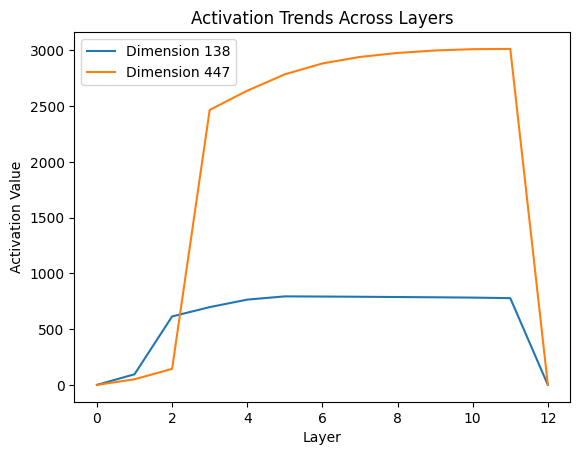

In [9]:
import matplotlib.pyplot as plt

layers = range(len(hidden_states))
activations_138 = [state[0, token_idx, 138].item() for state in hidden_states]
activations_447 = [state[0, token_idx, 447].item() for state in hidden_states]

plt.plot(layers, activations_138, label='Dimension 138')
plt.plot(layers, activations_447, label='Dimension 447')
plt.xlabel("Layer")
plt.ylabel("Activation Value")
plt.title("Activation Trends Across Layers")
plt.legend()
plt.show()


In [10]:
# Compare activations for multiple tokens
token_indices = [0, 2, 4]  # Indices for "The", "cat", and "mat"
for idx in token_indices:
    activations_138 = [state[0, idx, 138].item() for state in hidden_states]
    activations_447 = [state[0, idx, 447].item() for state in hidden_states]
    print(f"Token index {idx} - Dimension 138: {activations_138}")
    print(f"Token index {idx} - Dimension 447: {activations_447}")


Token index 0 - Dimension 138: [0.6178851127624512, 95.80139923095703, 614.3189697265625, 697.7620849609375, 765.0946655273438, 794.227294921875, 792.6949462890625, 790.655517578125, 788.322509765625, 786.0518798828125, 783.224853515625, 778.2894897460938, 0.6820380687713623]
Token index 0 - Dimension 447: [0.2649766504764557, 50.96592712402344, 144.26626586914062, 2465.75732421875, 2638.343017578125, 2785.01220703125, 2882.6259765625, 2941.271484375, 2976.834716796875, 2998.92333984375, 3010.63720703125, 3012.9267578125, 1.7013108730316162]
Token index 2 - Dimension 138: [0.005191154778003693, 0.26106423139572144, -0.24472354352474213, -0.43645212054252625, -0.7902849912643433, -0.9363500475883484, -0.7546308636665344, -0.5051351189613342, -0.4508659243583679, -0.46733415126800537, -0.6549252867698669, -1.7882347106933594, 0.5514386296272278]
Token index 2 - Dimension 447: [-0.05637553706765175, 25.842294692993164, 19.186771392822266, 25.849327087402344, 33.013946533203125, 39.1656723

In [12]:
# Compare activations for the same token in different contexts
inputs_1 = tokenizer("The cat sat on the mat.", return_tensors="pt")
inputs_2 = tokenizer("A dog ran on the mat.", return_tensors="pt")

with torch.no_grad():
    outputs_1 = model(**inputs_1, output_hidden_states=True)
    outputs_2 = model(**inputs_2, output_hidden_states=True)

hidden_states_1 = outputs_1.hidden_states
hidden_states_2 = outputs_2.hidden_states

token_idx = 0  # Index of "The" in both inputs
activations_1 = [state[0, token_idx, 138].item() for state in hidden_states_1]
activations_2 = [state[0, token_idx, 138].item() for state in hidden_states_2]

print(f"Activations for 'The' in input 1: {activations_1}")
print(f"Activations for 'A' in input 2: {activations_2}")


Activations for 'The' in input 1: [0.6178851127624512, 95.80139923095703, 614.3189697265625, 697.7620849609375, 765.0946655273438, 794.227294921875, 792.6949462890625, 790.655517578125, 788.322509765625, 786.0518798828125, 783.224853515625, 778.2894897460938, 0.6820380687713623]
Activations for 'A' in input 2: [0.5456602573394775, 96.34091186523438, 622.5074462890625, 710.3013305664062, 777.7281494140625, 807.0023803710938, 805.4462890625, 803.38720703125, 801.0384521484375, 798.7500610351562, 795.9002685546875, 790.9072265625, 0.6759279370307922]
